# Definition of Distribution A
## Setup

In [1]:
from datetime import datetime as dt
from matplotlib import pyplot as plot
from random import uniform
from sympy import Symbol, integrate, solve

from LocUtil import Grid1, SetSeed
from FileUtil import NewEndWritter

Define constants

In [2]:
nSamp = 100

givenSeed = None
seedDig = 3

nPlot = 101

fileName = '../dist_a.dill'

Define Symbols

In [3]:
xSym = Symbol('x')    # the random variable

aSym = Symbol('a')    # the probability at x=0
bSym = Symbol('b')    # the probability at x=1

qSym = Symbol('q')    # the quantile

## Define Elements of the Distribution
#### The PDF

In [4]:
form = aSym * (1 - xSym) + bSym * xSym
form

a*(1 - x) + b*x

To be a distribution the total probabilities must be one.  This implies that `a` and `b` are 
dependent.  Solve for `b` and express the distribution only in terms of `a`.

In [5]:
area = integrate(form, (xSym,0,1))
bExp = solve(area - 1, bSym)[0]
bExp

2 - a

Because both `a` and `b` must be non-negative, the range of `a` and `b` is (0,2).

In [6]:
form.subs(bSym, bExp).simplify()

-2*a*x + a + 2*x

In [7]:
pdfSym = 2*(1 - aSym) * xSym + aSym
pdfSym

a + x*(2 - 2*a)

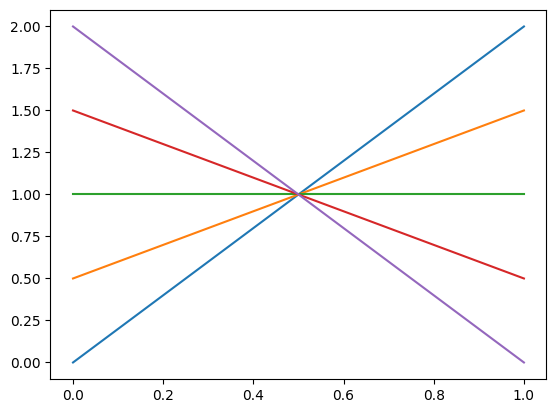

In [8]:
aL = Grid1(0,2,5)
xGrid = Grid1(0,1, nPlot)

for a in aL:
	pdfGrid = [pdfSym.subs(aSym,a).subs(xSym,x).evalf() for x in xGrid]
	plot.plot(xGrid,pdfGrid)

#### The CDF

In [9]:
cdfSym = integrate(pdfSym,xSym)
cdfSym

a*x + x**2*(1 - a)

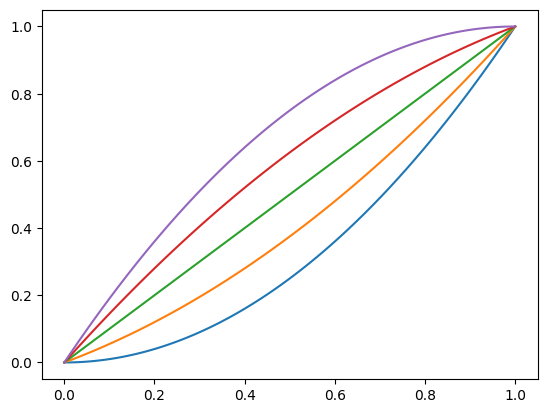

In [10]:
for a in aL:
	cdfGrid = [cdfSym.subs(aSym,a).subs(xSym,x).evalf() for x in xGrid]
	plot.plot(xGrid,cdfGrid)

#### Inverse CDF

In [11]:
temp = solve(cdfSym - qSym, xSym)
temp

[(a - sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1)),
 (a + sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1))]

In [12]:
invCdfSym = temp[0]
invCdfSym

(a - sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1))

There is a removable singularity at a = 1 ... need a library function for dealing with removable singularities. Would need to specify the required accuracy at the transition.

In [13]:
approxAt1 = invCdfSym.series(aSym,1).simplify().removeO()
approxAt1

q + (a - 1)**5*(21*(2*q - 1)**6 - 35*(2*q - 1)**4 + 15*(2*q - 1)**2 - 1)/32 + (a - 1)**4*(6*q + 7*(2*q - 1)**5 - 10*(2*q - 1)**3 - 3)/16 + (a - 1)**3*(5*(2*q - 1)**4 - 6*(2*q - 1)**2 + 1)/16 + (a - 1)**2*(-2*q + (2*q - 1)**3 + 1)/4 + (a - 1)*((2*q - 1)**2 - 1)/4

In [14]:
def InvCdfNum(q,a):
	if abs(a - 1) < 0.01:
		result = approxAt1.subs(aSym,a).subs(qSym,q).evalf()
	else:
		result = invCdfSym.subs(aSym, a).subs(qSym,q).evalf()
	  
	return result

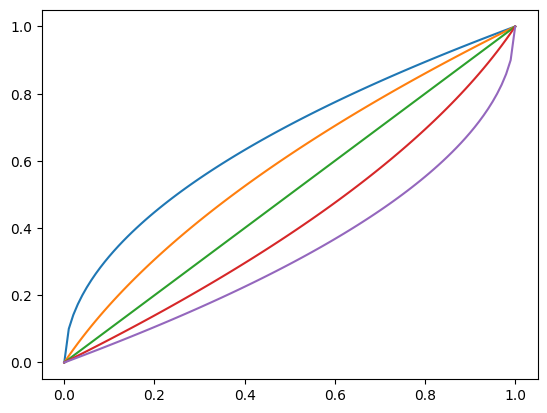

In [15]:
qGrid = Grid1(0,1, nPlot)

for a in aL:
	invCdfGrid = [InvCdfNum(x,a) for x in xGrid]
	plot.plot(xGrid,invCdfGrid)

## Sample Generation

In [16]:
def GenSamp(a, nSamp):
	sampCdf = [uniform(0,1) for _ in range(nSamp)]
	x = [InvCdfNum(q,a) for q in sampCdf]
	
	return x

In [17]:
seed = SetSeed(givenSeed, seedDig)
seed

189

In [18]:
a = uniform(0,2)
a

0.9668659243000086

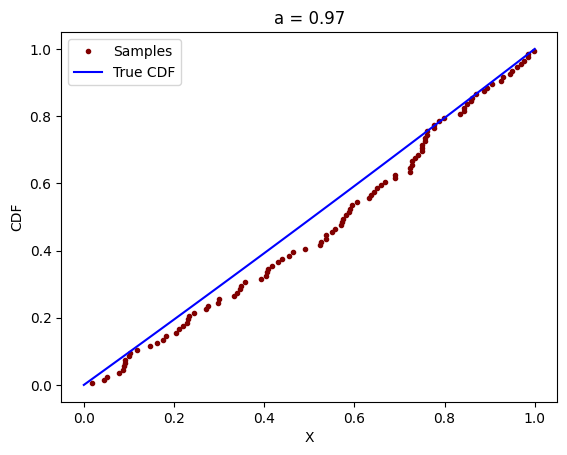

In [19]:
sampSort = sorted(GenSamp(a,nSamp))
quant = [(k + 0.5) / nSamp for k in range(nSamp)]

plot.plot(sampSort,quant, '.', c="Maroon", label='Samples')

xGrid = Grid1(0,1, nPlot)
qGrid = [cdfSym.subs(aSym,a).subs(xSym,x) for x in xGrid]
plot.plot(xGrid,qGrid, c='Blue', label='True CDF')

plot.xlabel('X')
plot.ylabel('CDF')

plot.title(f'a = {a:.2f}')
plot.legend()

## Generate Code for External Use

In [20]:
nameChange = {xSym: Symbol('xSym'), aSym: Symbol('aSym'), qSym: Symbol('qSym')}

In [21]:
pdfSymCode = f"pdfSym = {pdfSym.subs(nameChange)}\n"
cdfSymCode = f'cdfSym = {cdfSym.subs(nameChange)}\n'
invCdfSymCode = f'invCdfSym = {invCdfSym.subs(nameChange)}\n'

In [22]:
numFuncTemp = 'def {}(x,a):\n  return {}\n'

In [23]:
pdfNumCode = numFuncTemp.format('PdfNum', pdfSym)
cdfNumCode = numFuncTemp.format('CdfNum', cdfSym)

In [24]:
invCdfTemp = (
	'def InvCdfNum(q,a):\n'
	'  if abs(a - 1) < 0.01:\n'
	'    result = {}\n'
	'  else:\n'
	'    result = {}\n\n'
	'  return result\n'
)

In [25]:
invCdfCode = invCdfTemp.format(approxAt1, invCdfSym).replace('sqrt(', 'math.sqrt(')
invCdfCode

'def InvCdfNum(q,a):\n  if abs(a - 1) < 0.01:\n    result = q + (a - 1)**5*(21*(2*q - 1)**6 - 35*(2*q - 1)**4 + 15*(2*q - 1)**2 - 1)/32 + (a - 1)**4*(6*q + 7*(2*q - 1)**5 - 10*(2*q - 1)**3 - 3)/16 + (a - 1)**3*(5*(2*q - 1)**4 - 6*(2*q - 1)**2 + 1)/16 + (a - 1)**2*(-2*q + (2*q - 1)**3 + 1)/4 + (a - 1)*((2*q - 1)**2 - 1)/4\n  else:\n    result = (a - math.sqrt(a**2 - 4*a*q + 4*q))/(2*(a - 1))\n\n  return result\n'

In [26]:
genSampCode = (
	'def GenSamp(a):\n'
	'  q = uniform(0,1)\n'
	'  result = InvCdfNum(q,a)\n'
	'  return result\n'
)

In [27]:
code = (
	"import math\n"
	"from sympy import Symbol, sqrt\n"
	"from random import uniform\n\n"
	"xSym = Symbol('x')\n"
	"qSym = Symbol('q')\n"
	"aSym = Symbol('a')\n\n"
	f'{pdfSymCode}'
	f'{cdfSymCode}'
	f'{invCdfSymCode}\n\n'
	f"{pdfNumCode}\n"
	f"{cdfNumCode}\n"
	f"{invCdfCode}\n\n"
	f"{genSampCode}"
)

In [28]:
fileName = '../DistA.py'

In [29]:
with NewEndWritter(fileName) as file:
	file.write(code)

In [30]:
print(dt.now())

2024-06-26 18:25:09.382330
